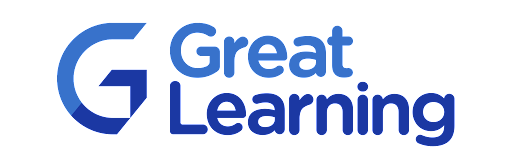

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Spam SMS Classification

## Domain
SMS, Text Data

## Business Context
The SMS spam is a growing problem considering availability of cheap sms packages offered by various telecom service companies. SMS spam filtering is a relatively new task which inherits many issues and solutions from email spam filtering. The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged according to ham (legitimate) or spam.
 
## Objective
Given a text message and label whether a sms is a spam message, can you train a model using LSTM that allows you to correctly predict a new sms as spam or ham. 



### Package version
- tensorflow==2.3.0
- matplotlib==3.2.1
- h5py==2.10.0
- google==2.0.3

## Table of Content

1. Import Libraries

2. Setting options

3. Read Data

4. Data Analysis and Preparation

5. Text Preprocessing

6. Model Building

7. Conclusion and Interpretation

## 1. Import Libraries

Let us start by mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let us check for the version of installed tensorflow.

In [ ]:
# used to supress display of warnings
import warnings

# os is used to provide a way of using operating system dependent functionality
# We use it for setting working folder
import os

# Pandas is used for data manipulation and analysis
import pandas as pd 

# Numpy is used for large, multi-dimensional arrays and matrices, along with mathematical operators on these arrays
import numpy as np

# Matplotlib is a data visualization library for 2D plots of arrays, built on NumPy arrays 
# and designed to work with the broader SciPy stack
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

# Seaborn is based on matplotlib, which aids in drawing attractive and informative statistical graphics.
import seaborn as sns
import tensorflow 
print(tensorflow.__version__)


from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

2.8.2


## 2. Setting Options

In [ ]:
# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

## 3. Read Data

Let us now, load the image files that is available in two separate folders

In [ ]:
data = pd.read_csv('/content/drive/My Drive/sms_spam_data.csv', encoding= 'latin-1')

In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Checking frequncy distribution of two classes

In [ ]:
pd.value_counts(data['v1'])

ham     4825
spam     747
Name: v1, dtype: int64

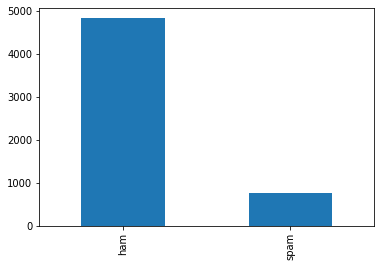

In [ ]:
pd.value_counts(data['v1']).plot(kind = 'bar')

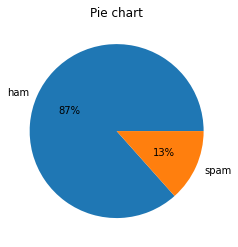

In [ ]:
data['v1'].value_counts().plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

#### Class is quite imbalanced and total number of samples is also less

## 4. Data Analysis and Preparation

Drop the columns that are not required for the model building

In [ ]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
data['v1'].replace('ham',0, inplace = True)
data['v1'].replace('spam',1, inplace = True)

In [ ]:
data.rename(columns={"v1":"Label","v2":"Message"},inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   int64 
 1   Message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


## 5. Text Preprocessing

In [ ]:
data['message_len'] = data['Message'].apply(len)
data.head()

,Label,Message,message_len
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


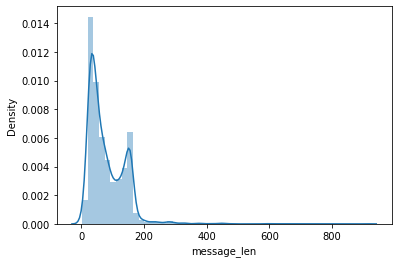

In [ ]:
sns.distplot(data['message_len'])

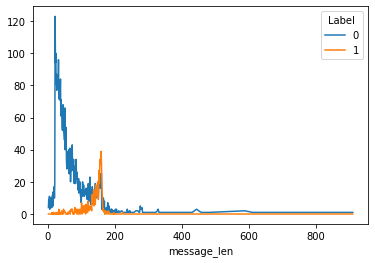

In [ ]:
pd.crosstab(data['message_len'],data['Label']).plot()

We can see that ham messages are relatively short and spam messages are longer in length. 

In [ ]:
data.describe()

,Label,message_len
count,5572.0000000,5572.0000000
mean,0.1340632,80.1188083
std,0.3407508,59.6908408
min,0.0000000,2.0000000
25%,0.0000000,36.0000000
50%,0.0000000,61.0000000
75%,0.0000000,121.0000000
max,1.0000000,910.0000000


In [ ]:
# Convert to lower case
data['text'] = data['Message'].apply(lambda x: x.lower())

In [ ]:
from nltk.corpus import stopwords
# Removing stop words
import string
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data['text'] = data['text'].apply(lambda words: ' '.join(word for word in words.split() if word not in stop))

In [ ]:
# Remove punctuations
data['text'] = data['text'].str.replace('[^\w\s]','')

In [ ]:
data.head(2)

,Label,Message,message_len,text
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni


In [ ]:
X = data['text']
y = data['Label']

## 6. Model building

### 6.1 LSTM Model
Let us now build the neural network model, fit the training data, test it and provide model summary. Feel free to play around with the network and get to a better solution.

In [ ]:
#Splitting the data into train and test set using default size
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data['text'],y,test_size=0.25)

In [ ]:
max_words = 1000
max_len = 100

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
# define model

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten


def rnn_model():
    # create model
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='Features')(layer)
    layer = Activation('relu')(layer)
    layer = Dense(1,name='Out')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Let us create an object of our model

In [ ]:
# build the model
model = rnn_model()

In [ ]:
# Compile model
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy']) ### Loss function = binary cross entropy

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 Features (Dense)            (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 Out (Dense)                 (None, 1)                 257       
                                                                 
 activation_3 (Activation)   (None, 1)                 0   

Let us fit our model on the training dataset along with it's equivalent one hot encoded labels

In [ ]:
# Fit the model
training_history = model.fit(sequences_matrix,Y_train,batch_size=32,epochs=20,
          validation_split=0.2)

Epoch 1/20
105/105 [==============================] - 11s 77ms/step - loss: 0.2572 - accuracy: 0.9097 - val_loss: 0.0615 - val_accuracy: 0.9821
Epoch 2/20
105/105 [==============================] - 7s 71ms/step - loss: 0.0604 - accuracy: 0.9812 - val_loss: 0.0500 - val_accuracy: 0.9880
Epoch 3/20
105/105 [==============================] - 7s 70ms/step - loss: 0.0316 - accuracy: 0.9916 - val_loss: 0.0504 - val_accuracy: 0.9880
Epoch 4/20
105/105 [==============================] - 7s 70ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 0.0544 - val_accuracy: 0.9856
Epoch 5/20
105/105 [==============================] - 8s 73ms/step - loss: 0.0121 - accuracy: 0.9970 - val_loss: 0.0688 - val_accuracy: 0.9833
Epoch 6/20
105/105 [==============================] - 7s 71ms/step - loss: 0.0360 - accuracy: 0.9910 - val_loss: 0.1122 - val_accuracy: 0.9641
Epoch 7/20
105/105 [==============================] - 8s 72ms/step - loss: 0.0302 - accuracy: 0.9889 - val_loss: 0.0696 - val_accuracy: 0.984

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

per = model.evaluate(test_sequences_matrix,Y_test)

44/44 [==============================] - 1s 18ms/step - loss: 0.2335 - accuracy: 0.9720


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(per[0],per[1]))

Test set
  Loss: 0.234
  Accuracy: 0.972


### 6.2 Naive Bayes Model

In [ ]:
#Splitting the data into train and test set using default size
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data['text'],y,test_size=0.25)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer()

In [ ]:
# learn training data vocabulary, then use it to create a document-term matrix
X_train_transformed = vectorizer.transform(X_train)

In [ ]:
X_test_transformed = vectorizer.transform(X_test)

In [ ]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [ ]:
nb.fit(X_train_transformed, Y_train)

MultinomialNB()

In [ ]:
# make class predictions for X_test
y_pred_class = nb.predict(X_test_transformed)

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score 
metrics.accuracy_score(Y_train, nb.predict(X_train_transformed))

0.9937784158889686

In [ ]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(Y_test, y_pred_class)

0.9842067480258435

In [ ]:
# print the confusion matrix
metrics.confusion_matrix(Y_test, y_pred_class)

array([[1201,    5],
       [  17,  170]])

# 7. Conclusion and Interpretation


- Both LSTM and Naive Bayes are able to perfrom very well on this data.
- We are able to get aprox. 98% accuracy with Naive Bayes

##. Further Explore

- Can you try changing a few hyperparameters such as number of layers in the network or number of units in a hidden layer or try different activation functions in the hidden layers and see if you get better results than the one in this notebook? 
- Can you analyze the false positive and false negative messages individually and figure out why the model made a mistake and how it can be improved?